# Appling machine learning to audio analysis

## Code for Predicting 

### Libraries

In [2]:
### Dependencies were already installed previously on ubuntu
### Comet: experiment tracking and visual tools

from comet_ml import Experiment

import IPython.display as ipd
import numpy as np
import pandas as pd
import librosa # audio analysis
import librosa.display # this submodule needs to be imported explicitly
import matplotlib.pyplot as plt
from scipy.io import wavfile as wav
import os

In [3]:
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [4]:
from tensorflow import keras
from keras.models import Sequential, save_model, load_model
from keras.layers import Dense, Dropout, Activation
# Keras now is fully integrated to Tensorflow, so to_categorical and Adam
# can't be imported directly from keras, therefore, the update:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

2022-01-06 14:39:31.322257: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-06 14:39:31.322323: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [5]:
# To play audio file:
import IPython.display as ipd

In [6]:
# Create a Comet Experiment, to capture any and all artifacts
# such as audio files, visualization, model, dataset, system information and training metrics
experiment = Experiment(api_key = "Xa6eGiuYFngDcAJ9PVY1WpZp0", project_name = "SetA")

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/negromontebs/seta/689a880ffe0a48b3aeb1feff564328fc



## MFCCs - Mel-Frequency Cepstrum Coefficients

### Functions to extract the MFCCs from every file in our dataset

In [6]:
# funçao com gerador que guarda os valores da atual posição da janela e calcula os proximos
def windows(audio, window_size):
    start = 0
    while start < len(audio):
        yield start, start + window_size # a função para aqui e returna o valor para a outra função
        start += (window_size // 2) #calcula a posição inicial do proximo segmento

In [7]:
def extract_features(file_name, window_size):
    #upload do audio
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    #list de retorno
    mfccsArr = []
    
    # A função gerador é um iteravel a partir dos valores gerados durante a keyword yield
    #Percorre um audio inteiro
    for (start,end) in windows(audio, window_size):
        #Enquanto a janela nao atingir o fim do audio
        if end <= len(audio): 
            #entao define um excerto do audio
            signal = audio[start:end]
            # e calcula os coeficientes de mel
            mfccs = librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=40)
            mfccs_processed = np.mean(mfccs.T,axis=0)
            mfccsArr.append([mfccs_processed])
    # Retorna os coeficientes de mel em forma de lista do audio inteiro
    return mfccsArr

### Code to save the MFCCs

In [8]:
features = []# Iterate through each sound file and extract the features 

df = pd.read_csv('../csvFiles/set_a.csv')

windowSize = 3000

In [47]:
for index, row in df.iterrows():
    
    absolutePath = os.path.abspath("../")
    fname = str(row["fname"])
    file_name = os.path.join(absolutePath,fname)
    
    
    data = extract_features(file_name, windowSize)
    
    for item in data:
        features.append(item)
    
# Convert into a Panda dataframe 
featuresdf = pd.DataFrame(features, columns=['feature'])

In [48]:
featuresdf.head()

,feature
0,"[-656.6555, 63.691227, -9.413803, 32.934563, -..."
1,"[-676.3987, 46.328228, -19.549753, 27.875717, ..."
2,"[-670.61273, 46.94281, -25.268034, 26.992773, ..."
3,"[-661.8272, 52.96385, -25.078768, 27.360682, -..."
4,"[-639.69, 70.559296, -17.338217, 29.466614, -6..."


In [51]:
featuresdf.iloc[0]['feature']
fileMFCCs = '../MFCCs/completeSetA_' + str(windowSize) + '.pkl'
featuresdf.to_pickle(fileMFCCs) 

## Model's Predections

### Load Model from saved files

In [10]:
model = load_model('../model_save/cut_setA', compile = True)

,feature
0,"[-656.6555, 63.691227, -9.413803, 32.934563, -..."
1,"[-676.3987, 46.328228, -19.549753, 27.875717, ..."
2,"[-670.61273, 46.94281, -25.268034, 26.992773, ..."
3,"[-661.8272, 52.96385, -25.078768, 27.360682, -..."
4,"[-639.69, 70.559296, -17.338217, 29.466614, -6..."


In [ ]:
fileMFCCs = '../MFCCs/completeSetA_' + '3000' + '.pkl'
featuresdf = pd.read_pickle(fileMFCCs)
featuresdf.head()

### Predections (SOFTMAX func)

In [11]:
X = np.array(featuresdf.feature.tolist())
predictions = model.predict(X)

In [12]:
print(predictions)

[[1.25253386e-33 2.23273200e-16 1.00000000e+00 4.49137136e-17]
 [1.04075367e-27 1.15067102e-10 1.00000000e+00 1.44307060e-12]
 [3.45570725e-25 1.00441735e-08 1.00000000e+00 2.08364367e-10]
 ...
 [2.61935359e-03 2.10122718e-03 9.95265126e-01 1.43354728e-05]
 [5.07884383e-01 4.88880605e-01 3.06161586e-03 1.73380831e-04]
 [5.00887752e-01 4.96174216e-01 2.73449603e-03 2.03553689e-04]]


### Plot of Predictions

No handles with labels found to put in legend.


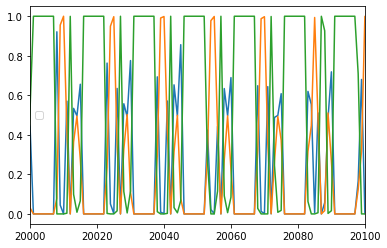

In [37]:
colSone = []
colSTwo = []
colNoise = []
colNoisesOne = []
for item in predictions:
     
    colSone.append(item[0])
    colSTwo.append(item[1])
    colNoise.append(item[2])
    colNoisesOne.append(item[2])

#print(colSone)


plt.plot(colSone)
plt.plot(colSTwo)
plt.plot(colNoise)
#plt.plot(colNoisesOne)
plt.xlim(20000, 20100)
plt.legend()

In [36]:
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/negromontebs/seta/c41343628574422f92a40d87b84d698b
COMET INFO:   Parameters:
COMET INFO:     Adam_amsgrad       : False
COMET INFO:     Adam_beta_1        : 0.8999999761581421
COMET INFO:     Adam_beta_2        : 0.9990000128746033
COMET INFO:     Adam_decay         : 0.0
COMET INFO:     Adam_epsilon       : 1e-07
COMET INFO:     Adam_learning_rate : 0.0010000000474974513
COMET INFO:     Optimizer          : Adam
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (47.12 KB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook                 : 1
COMET INFO:     os packages         